In [1]:
from IPython.display import YouTubeVideo
import cv2
import numpy as np
import os
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output # Extra

%matplotlib inline
# Open a new thread to manage the external cv2 interaction
cv2.startWindowThread()

def plt_show(image, title=""):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.title(title)
    plt.imshow(image, cmap="Greys_r")
    plt.show()

In [2]:
print(cv2.__version__)

3.1.0


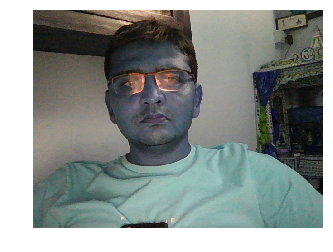

In [3]:
webcam = cv2.VideoCapture(0)
_ , frame = webcam.read()
cv2.waitKey(1000)
_ , frame = webcam.read()
webcam.release()
plt.imshow(frame)
plt.axis('off')
plt.show()

In [4]:
detector = cv2.CascadeClassifier("xml/frontal_face.xml")

scale_factor = 1.2
min_neighbors = 5
min_size = (30, 30)
biggest_only = True
flags = cv2.CASCADE_FIND_BIGGEST_OBJECT | \
            cv2.CASCADE_DO_ROUGH_SEARCH if biggest_only else \
            cv2.CASCADE_SCALE_IMAGE
        
faces_coord = detector.detectMultiScale(frame,
                                        scaleFactor=scale_factor,
                                        minNeighbors=min_neighbors,
                                        minSize=min_size,
                                        flags=flags)
print("Type: " + str(type(faces_coord)))
print(faces_coord)
print("Length: " + str(len(faces_coord))) 

Type: <class 'numpy.ndarray'>
[[154  56 236 236]]
Length: 1


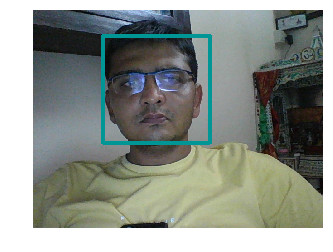

In [5]:
for (x, y, w, h) in faces_coord:
    cv2.rectangle(frame, (x, y), (x + w, y + h), (150, 150, 0), 8)
plt_show(frame) 

In [6]:
class FaceDetector(object):
    def __init__(self, xml_path):
        self.classifier = cv2.CascadeClassifier(xml_path)
    
    def detect(self, image, biggest_only=True):
        scale_factor = 1.2
        min_neighbors = 5
        min_size = (30, 30)
        biggest_only = True
        flags = cv2.CASCADE_FIND_BIGGEST_OBJECT | \
                    cv2.CASCADE_DO_ROUGH_SEARCH if biggest_only else \
                    cv2.CASCADE_SCALE_IMAGE
        faces_coord = self.classifier.detectMultiScale(image,
                                                       scaleFactor=scale_factor,
                                                       minNeighbors=min_neighbors,
                                                       minSize=min_size,
                                                       flags=flags)
        return faces_coord

In [7]:
class VideoCamera(object):
    def __init__(self, index=0):
        self.video = cv2.VideoCapture(index)
        self.index = index
        print(self.video.isOpened())

    def __del__(self):
        self.video.release()
    
    def get_frame(self, in_grayscale=False):
        _, frame = self.video.read()
        if in_grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return frame

In [8]:
webcam = VideoCamera()
detector = FaceDetector("xml/frontal_face.xml")

True


In [9]:
try:
    while True:
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame)
        for (x, y, w, h) in faces_coord:
            cv2.rectangle(frame, (x, y), (x + w, y + h), 
                          (150, 150, 0), 8)
        plt_show(frame) 
        clear_output(wait = True)
except KeyboardInterrupt:
     print("Live Video Interrupted")

Live Video Interrupted


In [10]:
def cut_faces(image, faces_coord):
    faces = []
      
    for (x, y, w, h) in faces_coord:
        w_rm = int(0.2 * w / 2)
        faces.append(image[y: y + h, x + w_rm: x + w - w_rm])
         
    return faces

Live Video Interrupted


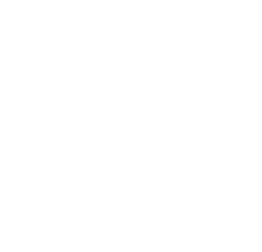

In [11]:
try:
    while True:
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame)
        if len(faces_coord):
            faces = cut_faces(frame, faces_coord)
            plt_show(faces[0])
            clear_output(wait = True)
except KeyboardInterrupt:
     print ("Live Video Interrupted")

In [12]:
def normalize_intensity(images):
    images_norm = []
    for image in images:
        is_color = len(image.shape) == 3 
        if is_color:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images_norm.append(cv2.equalizeHist(image))
    return images_norm

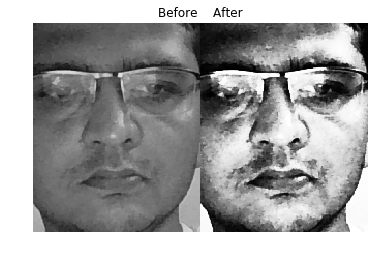

In [13]:
face_bw = cv2.cvtColor(faces[0], cv2.COLOR_BGR2GRAY)
face_bw_eq = cv2.equalizeHist(face_bw)
plt_show(np.hstack((face_bw, face_bw_eq)), "Before    After")

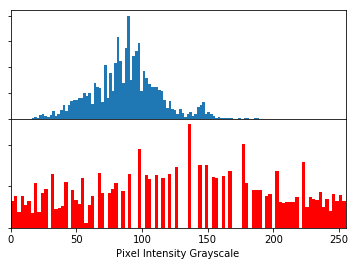

In [14]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
ax1.hist(face_bw.flatten(),100)
ax2.hist(face_bw_eq.flatten(),100, color = 'r')
ax1.set_xlim([0,255])
# ax1.set_ylim([0,1000])
ax2.set_xlim([0, 255])
# ax2.set_ylim([0, 700])
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax2.set_xlabel('Pixel Intensity Grayscale')
f.subplots_adjust(hspace=0) 
plt.show()

In [15]:
try:
    while True:
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame)
        if len(faces_coord): 
            faces = cut_faces(frame, faces_coord)
            faces = normalize_intensity(faces)
            plt_show(faces[0])
            clear_output(wait = True)
except KeyboardInterrupt:
     print ("Live Video Interrupted")

Live Video Interrupted


In [16]:
def resize(images, size=(50, 50)):
    images_norm = []
    for image in images:
        if image.shape < size:
            image_norm = cv2.resize(image, size, 
                                    interpolation = cv2.INTER_AREA)
        else:
            image_norm = cv2.resize(image, size, 
                                    interpolation = cv2.INTER_CUBIC)
        images_norm.append(image_norm)

    return images_norm 

In [17]:
try:
    while True:
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame)
        if len(faces_coord):
            faces = cut_faces(frame, faces_coord)
            faces = normalize_intensity(faces)
            faces = resize(faces)
            plt_show(faces[0])
            clear_output(wait = True)
except KeyboardInterrupt:
     print ("Live Video Interrupted")

Live Video Interrupted


In [18]:
def normalize_faces(frame, faces_coord):
    faces = cut_faces(frame, faces_coord)
    faces = normalize_intensity(faces)
    faces = resize(faces)
    return faces

def draw_rectangle(image, coords):
    for (x, y, w, h) in coords:
        w_rm = int(0.2 * w / 2) 
        cv2.rectangle(image, (x + w_rm, y), (x + w - w_rm, y + h), 
                              (150, 150, 0), 8)

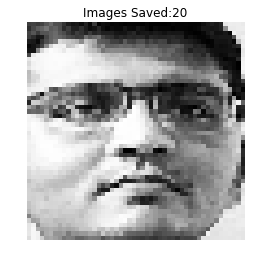

In [43]:
folder = "people/" + input('Person: ').lower() # input name
cv2.namedWindow("PyData Tutorial", cv2.WINDOW_AUTOSIZE)
if not os.path.exists(folder):
    os.mkdir(folder)
    counter = 1
    timer = 0
    while counter < 21 : # take 20 pictures
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame) # detect
        if len(faces_coord) and timer % 700 == 50: # every Second or so
            faces = normalize_faces(frame, faces_coord) # norm pipeline
            cv2.imwrite(folder + '/' + str(counter) + '.jpg', faces[0])
            plt_show(faces[0], "Images Saved:" + str(counter))
            clear_output(wait = True) # saved face in notebook
            counter += 1
        draw_rectangle(frame, faces_coord) # rectangle around face
        cv2.imshow("PyData Tutorial", frame) # live feed in external
        cv2.waitKey(50)
        timer += 50
    cv2.destroyAllWindows()
else:
    print ("This name already exists.")

In [42]:
cv2.destroyAllWindows()

In [44]:
def collect_dataset():
    images = []
    labels = []
    labels_dic = {}
    people = [person for person in os.listdir("people/")]
    for i, person in enumerate(people):
        labels_dic[i] = person
        for image in os.listdir("people/" + person):
            images.append(cv2.imread("people/" + person + '/' + image, 
                                     0))
            labels.append(i)
    return (images, np.array(labels), labels_dic)

In [20]:
collect_dataset()

([array([[  1,   8,  10, ...,  11,  32, 191],
         [  3,  10,  15, ...,  11,  58, 163],
         [  8,   9,  13, ...,   3,  25,  90],
         ..., 
         [ 48,  54,  48, ..., 229, 232, 233],
         [ 48,  62,  52, ..., 231, 230, 230],
         [ 44,  55,  86, ..., 231, 232, 232]], dtype=uint8),
  array([[  1,   3,   2, ..., 218, 196, 181],
         [  3,   3,   0, ..., 216, 201, 178],
         [  0,   4,   1, ..., 220, 223, 193],
         ..., 
         [ 26,  25,  26, ...,  71,  70,  77],
         [ 32,  28,  27, ...,  69,  64,  55],
         [ 39,  35,  35, ..., 188, 206, 121]], dtype=uint8),
  array([[ 20,  19,  23, ...,   7, 108, 156],
         [ 16,  19,  24, ..., 108,  37, 201],
         [ 21,  19,  28, ..., 207,  21,  61],
         ..., 
         [ 14,  20,  36, ..., 243, 242, 242],
         [ 11,  21,  40, ..., 244, 244, 243],
         [ 12,  17,  29, ..., 242, 242, 242]], dtype=uint8),
  array([[  7,   8,   9, ...,   9,  15,  14],
         [  6,  11,  10, ...,  13,  

In [45]:
images, labels, labels_dic = collect_dataset()

rec_eig = cv2.face.createEigenFaceRecognizer()
rec_eig.train(images, labels)

# needs at least two people 
rec_fisher = cv2.face.createFisherFaceRecognizer()
rec_fisher.train(images, labels)

rec_lbph = cv2.face.createLBPHFaceRecognizer()
rec_lbph.train(images, labels)

print ("Models Trained Succesfully")

Models Trained Succesfully


In [26]:
del webcam

In [27]:
webcam = VideoCamera()

True


In [28]:
cv2.namedWindow("Welcome to My World", cv2.WINDOW_NORMAL)


In [31]:
from IPython.display import clear_output
try:
    while True:
        frame = webcam.get_frame()
        plt_show(frame)
        clear_output(wait=True)
except KeyboardInterrupt:
    print ("Live Video Interrupted")

Live Video Interrupted


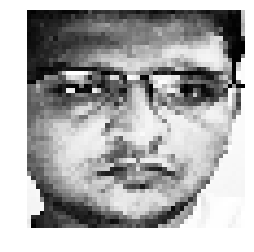

In [32]:
detector = FaceDetector("xml/frontal_face.xml")
cv2.waitKey(2000)
faces_coord = detector.detect(frame)
cv2.waitKey(2000)
faces = normalize_faces(frame, faces_coord)
cv2.waitKey(2000)
face = faces[0]
plt_show(face)

In [33]:
#Cancel this function there is too much lag required. Bifurcate into multiple tasks for variable assignment.
#webcam = VideoCamera()
#frame = webcam.get_frame()
#detector = FaceDetector("xml/frontal_face.xml")
#cv2.waitKey(2000)
#frame = webcam.get_frame()
#cv2.waitKey(2000)
#faces_coord = detector.detect(frame)
#cv2.waitKey(2000)
#faces = normalize_faces(frame, faces_coord)
#cv2.waitKey(2000)
#face = faces[0]
#plt_show(face)
del webcam

In [46]:
collector = cv2.face.MinDistancePredictCollector()

rec_eig.predict(face, collector)
conf = collector.getDist()
pred = collector.getLabel()
print ("Eigen Faces -> Prediction: " + labels_dic[pred].capitalize() +\
"    Confidence: " + str(round(conf)))

rec_fisher.predict(face, collector)
conf = collector.getDist()
pred = collector.getLabel()
print ("Fisher Faces -> Prediction: " +\
labels_dic[pred].capitalize() + "    Confidence: " + str(round(conf)))

rec_lbph.predict(face, collector)
conf = collector.getDist()
pred = collector.getLabel()

print ("LBPH Faces  -> Prediction: " + labels_dic[pred].capitalize() +\
"    Confidence: " + str(round(conf)) )

Eigen Faces -> Prediction: Dhaval mandalia    Confidence: 1325
Fisher Faces -> Prediction: Dhaval mandalia    Confidence: 179
LBPH Faces  -> Prediction: Dhaval mandalia    Confidence: 123


In [37]:
detector = FaceDetector("xml/frontal_face.xml")
webcam = VideoCamera(0)

True


In [47]:
cv2.namedWindow("PyData Tutorial", cv2.WINDOW_AUTOSIZE)
while True:
    frame = webcam.get_frame()
    faces_coord = detector.detect(frame, True) # detect more than one face
    if len(faces_coord):
        faces = normalize_faces(frame, faces_coord) # norm pipeline
        for i, face in enumerate(faces): # for each detected face
            collector = cv2.face.MinDistancePredictCollector()
            rec_lbph.predict(face, collector)
            conf = collector.getDist()
            pred = collector.getLabel()
            threshold = 140
            #print "Prediction: " + labels_dic[pred].capitalize() + "\nConfidence: " + str(round(conf))
            cv2.putText(frame, labels_dic[pred].capitalize(),
                        (faces_coord[i][0], faces_coord[i][1] - 10),
                        cv2.FONT_HERSHEY_PLAIN, 3, (66, 53, 243), 2)
        clear_output(wait = True)
        draw_rectangle(frame, faces_coord) # rectangle around face
    cv2.putText(frame, "ESC to exit", (5, frame.shape[0] - 5),
                    cv2.FONT_HERSHEY_PLAIN, 1.3, (66, 53, 243), 2, cv2.LINE_AA)
    cv2.imshow("PyData Tutorial", frame) # live feed in external
    if cv2.waitKey(40) & 0xFF == 27:
        cv2.destroyAllWindows()
        break

In [39]:
cv2.namedWindow("PyData Tutorial", cv2.WINDOW_AUTOSIZE)
while True:
    frame = webcam.get_frame()
    faces_coord = detector.detect(frame, False) # detect more than one face
    if len(faces_coord):
        faces = normalize_faces(frame, faces_coord) # norm pipeline
        for i, face in enumerate(faces): # for each detected face
            collector = cv2.face.MinDistancePredictCollector()
            rec_lbph.predict(face, collector)
            conf = collector.getDist()
            pred = collector.getLabel()
            threshold = 140
            #print "Prediction: " + labels_dic[pred].capitalize() + "\nConfidence: " + str(round(conf))
            clear_output(wait = True)
            if conf < threshold: # apply threshold
                cv2.putText(frame, labels_dic[pred].capitalize(),
                            (faces_coord[i][0], faces_coord[i][1] - 10),
                            cv2.FONT_HERSHEY_PLAIN, 3, (66, 53, 243), 2)
            else:
                cv2.putText(frame, "Unknown",
                            (faces_coord[i][0], faces_coord[i][1]),
                            cv2.FONT_HERSHEY_PLAIN, 3, (66, 53, 243), 2)
        draw_rectangle(frame, faces_coord) # rectangle around face
    cv2.putText(frame, "ESC to exit", (5, frame.shape[0] - 5),
                    cv2.FONT_HERSHEY_PLAIN, 1.3, (66, 53, 243), 2, cv2.LINE_AA)
    cv2.imshow("PyData Tutorial", frame) # live feed in external
    if cv2.waitKey(40) & 0xFF == 27:
        cv2.destroyAllWindows()
        break